In [1]:
import requests, json, numpy, datetime
import pywren
import boto3
import numpy as np
from pyproj import Proj
import warnings
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [37]:
# Leaving this here if needed: https://medium.com/@jenoyamma/how-to-install-python-packages-for-aws-lambda-layer-74e193c76a91
BUCKET = 'mapping-disaster-risk'

GEOJSONS = ['train-borde_rural.geojson', 'train-borde_soacha.geojson',
            'train-castries.geojson', 'train-dennery.geojson',
            'train-gros_islet.geojson', 'train-mixco_1_and_ebenezer.geojson',
            'train-mixco_3.geojson']

TIFS = ['borde_rural_ortho-cog.tif', 'borde_soacha_ortho-cog.tif',
        'castries_ortho-cog.tif', 'dennery_ortho-cog.tif',
        'gros_islet_ortho-cog.tif', 'mixco_1_and_ebenezer_ortho-cog.tif',
        'mixco_3_ortho-cog.tif']

tif_list = [{'tif':"mixco_3_ortho-cog.tif",
    'crs': 'epsg:32616',
    'geojson': 'train-mixco_3.geojson',
    'output': 'guatemala_mixco_3_zonal.csv'}]



In [3]:
# Note that all geojsonn names are the object names as well, so to access an object call:
# https://mapping-disaster-risk.s3.amazonaws.com/train-borde_rural.geojson

In [49]:
# Step 1: Get all geojsons and create new footprint dictionaries
def get_geojsons(dictionary):
    '''
    Given a full geojson dictionary, extracts relevant information for each
    building, including type, building id, roof material, and coordinates.
    Returns a list of dictionaries, where each dictionary maps a building by
    these features.
   
    Input:
        geojson (str): name of geojson dictionary
    
    Output:
        polygons (lst): a list of dictionaries (one per building)
    '''
    geojson = dictionary['geojson']
    tif = dictionary['tif']
    crs = dictionary['crs']
    output = dictionary['output']

    try:
        s3 = boto3.client('s3', 'us-east-1')
        obj = s3.get_object(Bucket='mapping-disaster-risk', Key=geojson)
        geo_json = json.load(obj['Body'])
        polygons = []
#         these are duplicating coordinates?
#         for feature in geo_json['features']:
#             polygon = {}
#             polygon['type'] = feature['geometry']
#             polygon['bid'] = feature['id']
#             polygon['roof_material'] = feature['properties']['roof_material']
#             polygon['coordinates'] = feature['geometry']['coordinates']
#             polygon['geojson'] = geojson
#             polygon['tif'] = tif
#             polygon['crs'] = crs
#             polygon['output'] = output
#             polygons.append(polygon)
    except Exception as e:
        return e

    return geo_json

In [5]:
# def transform_coordinates(list_polygon_list):
#     '''
#     Given building footprints, executes an affine transformation on each
#     coordinate pair to output a new coordinate pair based on a provided
#     coordinate reference system (crs) from the corresponding geotiff file.
#     Serial since Proj is not natively installed on Lambda.
    
#     Input:
#         polygon_list (lst): one dictionary footprint per building

#     Output:
#         updated_polygons (lst): a list of dictionaries (one per building)
#     '''
#     final_lst = []
#     for polygon_list in list_polygon_list:
#         geojson = polygon_list[0]['geojson']
#         crs = polygon_list[0]['crs']
#         tif = polygon_list[0]['tif']
#         transform = Proj(init=crs)

#         updated_polygons = []
#         for polygon in polygon_list:
#             for coordinates_list in polygon['coordinates']:
#                 inner_coord_list = []
#                 for coordinate in coordinates_list:
#                     transformed_coordinate = list(transform(coordinate[0],
#                                                             coordinate[1]))
#                     inner_coord_list.append(transformed_coordinate)        
#                 polygon['coordinates'] = inner_coord_list
#                 updated_polygons.append(polygon)
#         final_lst.append(updated_polygons)

#     return final_lst

In [18]:
def get_rooftop_array_after_mask(polygons):
    '''
    Given a dictionary containing transformed coordinates for one roof,
    returns an array of arrays, each one providing a numeric value for each
    pixel in the image for a specific band (in this case, 4 matrices for 4
    bands).
    Eg. Values from 0-255 correspond with the color scale.
    Input:
        tiff_path (str): path to the tif file
        polygon (dict): a dictionary of features including coordinates for a
                        single building
    Output:
        out_image (numpy array): a numpy of values per pixel for each
                                 band (one per image layer)
    '''
    #tif = polygons['tif']
    URL = 'https://mapping-disaster-risk.s3.amazonaws.com/' + polygons[0]
    
    tiff = rasterio.open(URL)
    name = tiff.name

#         rv = pd.DataFrame()
#         for polygon in polygons[:2]: # Fix this to call all polygons
#             try:
#                 brick, out_transform = mask(tiff, [polygon], crop=True)
#                 c, y, x = brick.shape

#                 # Crop the center of the image
#                 startx = x//2 - 60//2
#                 starty = y//2 - 60//2
#                 brick = brick[:3, starty:starty+60, startx:startx+60]

#                 # Calculate Zonal Stats Per Band
#                 df = pd.DataFrame()
#                 for i in range(brick.shape[0] - 1):
#                     df[i] = pd.Series(np.median(brick[i]))
#                 df['roof'] = polygon['roof_material']
#                 df.set_index('roof', inplace=True)     
#                 rv = pd.concat([rv, df])

#             except Exception as e:
#                  print(e)

    return name #rv # Returns a dataframe

In [19]:
def map_tiff(polygon):

    URL = 'https://mapping-disaster-risk.s3.amazonaws.com/mixco_3_ortho-cog.tif'
    
    try:
#         s3 = boto3.client('s3', 'us-east-1')
#         obj = s3.get_object(Bucket='mapping-disaster-risk', Key=geojson)
#         geo_json = json.load(obj['Body'])
        
        tiff = rasterio.open(URL)
        rv = tiff.shape


    except Exception as e:
        return e

    return rv

In [20]:
def get_geojsons_JAMES(geojson):
    
    try:
        s3 = boto3.client('s3', 'us-east-1')
        obj = s3.get_object(Bucket='mapping-disaster-risk', Key=geojson)
        geo_json = json.load(obj['Body'])

    except Exception as e:
        return e

    return geo_json

In [21]:
# MY VERSION OF GEOJSON
pwex = pywren.default_executor()
futures = pwex.map(get_geojsons_JAMES, GEOJSONS)

In [22]:
all_geojsons = pywren.get_all_results(futures)

In [23]:
# FROM UML PROJECT, CAN BE DELETED BECAUSE IT IS HANDLED IN GET GEOJSON
def make_polygons(geojson):

    polygons = []

    for feature in geojson['features']:
        polygon = {}
        polygon['type'] = feature['geometry']['type']
        polygon['bid'] = feature['id']
        polygon['roof_material'] = feature['properties']['roof_material']
        polygon['coordinates'] = feature['geometry']['coordinates']
        polygons.append(polygon)

    return polygons

In [24]:
# polygons_UML = make_polygons(geojson)

In [25]:
# FROM THE UML project
def transform_coordinates_UML(polygon):
    
    transform = Proj(init='epsg:32616')
    coordinates_lists = polygon['coordinates']
    transformed_coordinates_lists = []
    
    for coordinates_list in coordinates_lists:
        inner_coord_list = []
        for coordinate in coordinates_list:
            transformed_coordinate = list(transform(coordinate[0],
                                                    coordinate[1]))
            inner_coord_list.append(transformed_coordinate)
        transformed_coordinates_lists.append(inner_coord_list)
    
    polygon['coordinates'] = transformed_coordinates_lists
    
    return polygon

In [26]:
# transformed_polygons_UML = transform_coordinates_UML(polygons_UML[0])

In [52]:
# ALL GEOJSONS // ONLY THE GEOJSON ASSOCIATED WITH MIXCO 3 
pwex = pywren.default_executor()
futures = pwex.map(get_geojsons, tif_list)
geojsons = pywren.get_all_results(futures)

In [55]:
polygons = make_polygons(geojsons[0])

In [60]:
# TRYING TO PARALLEIZE TRANSFORM // DISCUSS WHAT WENT WRONG AND ISSUES WITH PYPROJ
# pwex = pywren.default_executor()
# futures = pwex.map(transform_coordinates_UML, polygons)

In [58]:
# SERIALIZE TRANSFORM IF NECESSARY
transformed_polygons = []
for polygon in polygons:
    transformed = transform_coordinates_UML(polygon)
    transformed_polygons.append(transformed)

In [44]:
transformed_polygons = transform_coordinates(polygons)

In [45]:
transformed_polygons

[{'type': {'type': 'Polygon',
   'coordinates': [[[-90.5762815717411, 14.613690151674064],
     [-90.57625574335032, 14.61374490786261],
     [-90.57619788775492, 14.613722178878561],
     [-90.57622268301009, 14.613664323283274],
     [-90.5762815717411, 14.613690151674064]]]},
  'bid': '7a243732',
  'roof_material': 'healthy_metal',
  'coordinates': [[114621.56319916528, 1618636.4860979326],
   [114624.44529400894, 1618642.5086115145],
   [114630.64719661477, 1618639.8920392655],
   [114627.87114600663, 1618633.524383647],
   [114621.56319916528, 1618636.4860979326]],
  'geojson': 'train-mixco_3.geojson',
  'tif': 'mixco_3_ortho-cog.tif',
  'crs': 'epsg:32616',
  'output': 'guatemala_mixco_3_zonal.csv'},
 {'type': {'type': 'Polygon',
   'coordinates': [[[-90.57681983540516, 14.613585804975287],
     [-90.57680227209943, 14.613620931586809],
     [-90.57675144182627, 14.613595516450289],
     [-90.57676900513201, 14.613560389838824],
     [-90.57681983540516, 14.613585804975287]]]},
 

In [31]:
results = pywren.get_all_results(futures)

In [8]:
s3 = boto3.client('s3', 'us-east-1')

In [9]:
obj = s3.get_object(Bucket='mapping-disaster-risk', Key='train-borde_soacha.geojson')

In [10]:
geo_json = json.load(obj['Body'])

In [7]:
futures[1].result()

'train-borde_soacha.geojson'

In [8]:
# Transform coordinates (note: serial since Proj cannot easily be used with Lambda)
new_polygons = transform_coordinates(polygons)

In [9]:
#URL = 'https://mapping-disaster-risk.s3.amazonaws.com/mixco_3_ortho-cog.tif'
#mixco_3 = new_polygons[3]
pwex = pywren.default_executor()
futures = pwex.map(get_rooftop_array_after_mask, ['mixco_3_ortho-cog.tif'])
dataframes = pywren.get_all_results(futures)

OSError: [Errno 28] No space left on device

In [73]:
print(mixco_3[0])

{'type': {'type': 'Polygon', 'coordinates': [[[-90.5762815717411, 14.613690151674064], [-90.57625574335032, 14.61374490786261], [-90.57619788775492, 14.613722178878561], [-90.57622268301009, 14.613664323283274], [-90.5762815717411, 14.613690151674064]]]}, 'bid': '7a243732', 'roof_material': 'healthy_metal', 'coordinates': [[114621.56319916528, 1618636.4860979326], [114624.44529400894, 1618642.5086115145], [114630.64719661477, 1618639.8920392655], [114627.87114600663, 1618633.524383647], [114621.56319916528, 1618636.4860979326]], 'geojson': 'train-mixco_3.geojson', 'tif': 'mixco_3_ortho-cog.tif', 'crs': 'epsg:32616', 'output': 'guatemala_mixco_3_zonal.csv'}


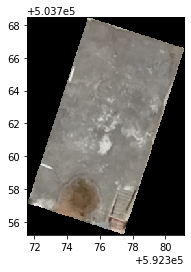

(336, 243)


In [50]:
# Open an individual rooftop
with rasterio.open('https://mapping-disaster-risk.s3.amazonaws.com/tst3.tif') as tiff:
    show(tiff)
    print(tiff.shape)

In [35]:

with rasterio.open(URL) as tiff:
    print(tiff.meta)
    #tiff.read(1)



{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 19271, 'height': 26066, 'count': 4, 'crs': CRS.from_epsg(32616), 'transform': Affine(0.037884682197416183, 0.0, 114414.52377475728,
       0.0, -0.037884682197416183, 1618709.3919501214)}


In [13]:
s3 = boto3.client('s3', 'us-east-1')
obj = s3.get_object(Bucket='mapping-disaster-risk', Key='mixco_3_ortho-cog.tif')
#test = json.loads(obj['Body'].read().decode("ISO-8859-1")) 
#obj['Body'].read(200).decode('utf-8')

In [16]:
print(obj['Body'].read('name'))

TypeError: string argument without an encoding

In [11]:
from rio_tiler.io import cogeo

tile, mask = cogeo.tile(
  'https://mapping-disaster-risk.s3.amazonaws.com/mixco_3_ortho-cog.tif',
  0,
  1,
  1,
)


TileOutsideBounds: Tile 1/0/1 is outside image bounds